<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/master/09-neural-networks/NNs_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Task 1: maximum likelihood fit (3 points)

Let's generate a Gaussian mixture dataset and then fit its parameters with maximum likelihood.

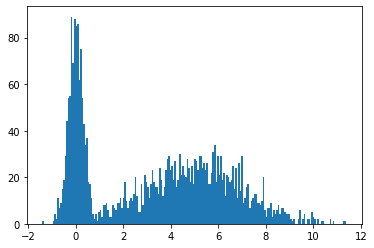

In [2]:
X1 = np.random.normal(size=1000, scale=0.3).astype('float32')
X2 = np.random.normal(size=2000, loc=5., scale=2.).astype('float32')

X = np.concatenate([X1, X2])
np.random.shuffle(X)

plt.hist(X, bins=200);

**Task**:
 - fill the gaps below to perform the max. likelihood fit with the pdf:
$$\text{PDF}(x|\mu_1, \sigma^2_1, \mu_2, \sigma^2_2, \alpha)
= \alpha\cdot\mathscr{N}(x|\mu_1, \sigma_1^2) + (1 - \alpha)\cdot\mathscr{N}(x|\mu_2, \sigma_2^2)$$
 - what the fitted values of $\mu_1, \sigma^2_1, \mu_2, \sigma^2_2$ and $\alpha$ should be? does your fit converge to them?

In [4]:
from types import prepare_class
from IPython.display import clear_output
import math

# Defining Gaussian PDF using torch functions
def gaussian(x, mu, sigma):
    #torch.pi = torch.acos(torch.zeros(1)).item() * 2
    #return torch.div(1, torch.sqrt(torch.pow(sigma, 2) * 2 * torch.pi)) * torch.exp(torch.tensor(torch.pow(-1/2 * (torch.tensor(x) - mu) / sigma, 2)))# use torch.exp for the exponent, don't forget the normalization
    return 1 / math.sqrt(sigma**2 * 2 * math.pi) * torch.exp(-1/2 * ((torch.tensor(x) - mu)/sigma)**2)

# Arbitrary mixture PDF
def mixture(x, f1, f2, alpha):
    return alpha * f1(x) + (1. - alpha) * f2(x)

# Parameters that we'd like to infer (with an initial guess)
m1    = torch.tensor([1.0], requires_grad=True) #requires_grad?
m2    = torch.tensor([4.0], requires_grad=True)
s1    = torch.tensor([1.0], requires_grad=True)
s2    = torch.tensor([1.0], requires_grad=True)
alpha = torch.tensor([0.5], requires_grad=True)

# At each gradient update we'll apply this function to
# ensure valid parameter values
def apply_constraints():
  #<YOUR CODE> # ensure the sigmas are positive (greater or equal to some small
              # positive number, e.g. 1e-5) and alpha is in (0, 1) interval
    
    torch.clamp(s1, min=1e-5)
    torch.clamp(s2, min=1e-5)
    torch.clamp(alpha, 0, 1)

variables = [m1, m2, s1, s2, alpha]

# Defining the overall PDF
def model_pdf(x):
  return mixture(x,
                 lambda t: gaussian(t, m1, s1),
                 lambda t: gaussian(t, m2, s2),
                 alpha)
    
# Log likelihood
def loglike(x): 
    
    return torch.sum(torch.log(model_pdf(x)))
    

learning_rate = 0.0001
grad_history = [] # to keep track of gradient values at different steps

for i in range(30):
  # Forward pass:
  l = loglike(X)
  #print(l)
  l.backward()



  m1 += (learning_rate * m1.grad)
  m2 += (learning_rate * m2.grad)
  s1 += (learning_rate * s1.grad)
  s2 += (learning_rate * s2.grad)
  alpha += (learning_rate * alpha.grad)
  grad_history.append([torch.clone(m1), torch.clone(m2), torch.clone(s1), torch.clone(s2), torch.clone(alpha)])
        #grad_history.append([m1.numpy(force=True),m2.numpy(force=True),s1.numpy(force=True),s2.numpy(force=True),alpha.numpy(force=True)])
  m1.grad.zero_()
  m2.grad.zero_()
  s1.grad.zero_()
  s2.grad.zero_()
  alpha.grad.zero_()
  #with torch.no_grad():
  #      m1.add_(learning_rate * m1.grad)
  #      m2.add_(learning_rate * m2.grad)
  #      s1.add_(learning_rate * s1.grad)
  #      s2.add_(learning_rate * s2.grad)
  #      alpha.add_(learning_rate * alpha.grad)
  #      grad_history.append([torch.clone(m1), torch.clone(m2), torch.clone(s1), torch.clone(s2), torch.clone(alpha)])
  #      #grad_history.append([m1.numpy(force=True),m2.numpy(force=True),s1.numpy(force=True),s2.numpy(force=True),alpha.numpy(force=True)])
  #      m1.grad.zero_()
  #      m2.grad.zero_()
  #      s1.grad.zero_()
  #      s2.grad.zero_()
  #      alpha.grad.zero_()
  print(grad_history)
  #print(m1, m1.grad)
  #grad_m1 = m1.grad
  #grad_m2 = m2.grad
  #grad_s1 = s1.grad
  #grad_s2 = s2.grad
  #grad_alpha = alpha.grad
  #print(grad_m1)
  #cur_grads = [grad_m1, grad_m2, grad_s1, grad_s2, grad_alpha]
  #print(cur_grads)
  #grad_history.append(cur_grads)
  #variables += [learning_rate * x for x in cur_grads]
  # Backprop
  # Gradient ascent step
  apply_constraints()
  ############################
  # Do some plotting
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.hist(X, bins=200, density=True, label='data')
  x_grid = np.linspace(-2, 12, 150)
  plt.plot(x_grid, model_pdf(x_grid).detach(), label='fit')
  plt.legend()
  plt.xlabel('X')

  plt.subplot(1, 2, 2)
  lines = plt.plot(np.array(grad_history))
  low = min(grad_history[-1])
  high = max(grad_history[-1])
  plt.ylim(low  - (high - low) * 0.6,
           high + (high - low) * 0.6)
  plt.legend(lines, ['m1', 'm2', 's1', 's2', 'alpha'])
  plt.xlabel('step')
  plt.ylabel('gradient')
  plt.show()
  clear_output(wait=True);

RuntimeError: ignored

# Task 2: classifying clothes (3 points)

In [13]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))
                               ])

# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



[['Dress' 'Pullover' 'Sneaker' 'Dress' 'Pullover' 'Shirt' 'Coat' 'Dress']
 ['Sneaker' 'Sneaker' 'Pullover' 'Ankle boot' 'Sandal' 'Pullover'
  'Sandal' 'Ankle boot']
 ['Bag' 'Bag' 'Shirt' 'Trouser' 'Bag' 'Trouser' 'Trouser' 'Sandal']
 ['Ankle boot' 'Sandal' 'Sandal' 'Coat' 'Sneaker' 'Trouser' 'Shirt' 'Bag']
 ['Sneaker' 'Sandal' 'Ankle boot' 'Shirt' 'Shirt' 'Ankle boot' 'Dress'
  'Shirt']
 ['Dress' 'Bag' 'Sneaker' 'Ankle boot' 'Shirt' 'Trouser' 'Sandal'
  'Ankle boot']
 ['Trouser' 'Sandal' 'Trouser' 'Bag' 'Pullover' 'Dress' 'Sneaker'
  'Sneaker']
 ['Coat' 'Bag' 'T-shirt/top' 'Trouser' 'T-shirt/top' 'Pullover' 'Dress'
  'Shirt']]
tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, 

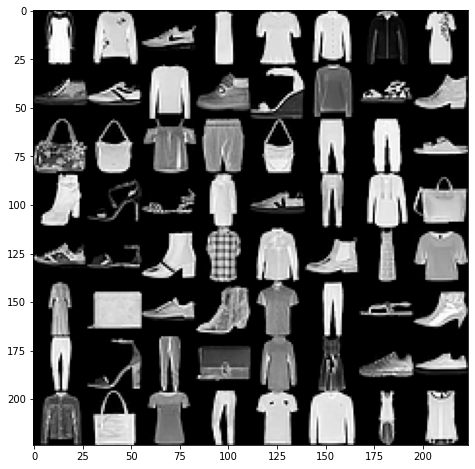

In [14]:
# Array for decoding the categories
label_names = np.array(['T-shirt/top',
                        'Trouser',
                        'Pullover',
                        'Dress',
                        'Coat',
                        'Sandal',
                        'Shirt',
                        'Sneaker',
                        'Bag',
                        'Ankle boot'])

# Get a single data batch of 64 images
sample_images, sample_labels = next(iter(trainloader))

# Plot the images in a 8x8 grid
plt.figure(figsize=(8, 8))
plt.imshow(
    sample_images.numpy().reshape(8, 8, 28, 28).transpose((0, 2, 1, 3)).reshape(224, 224),
    cmap='gray'
)
# Print corresponding labels
print(label_names[sample_labels.numpy().reshape(8, 8)])
print(sample_images)

**Task**:

Train a model which is an average of two models with different numbers of layers on the Fashion MNIST dataset, e.g.:

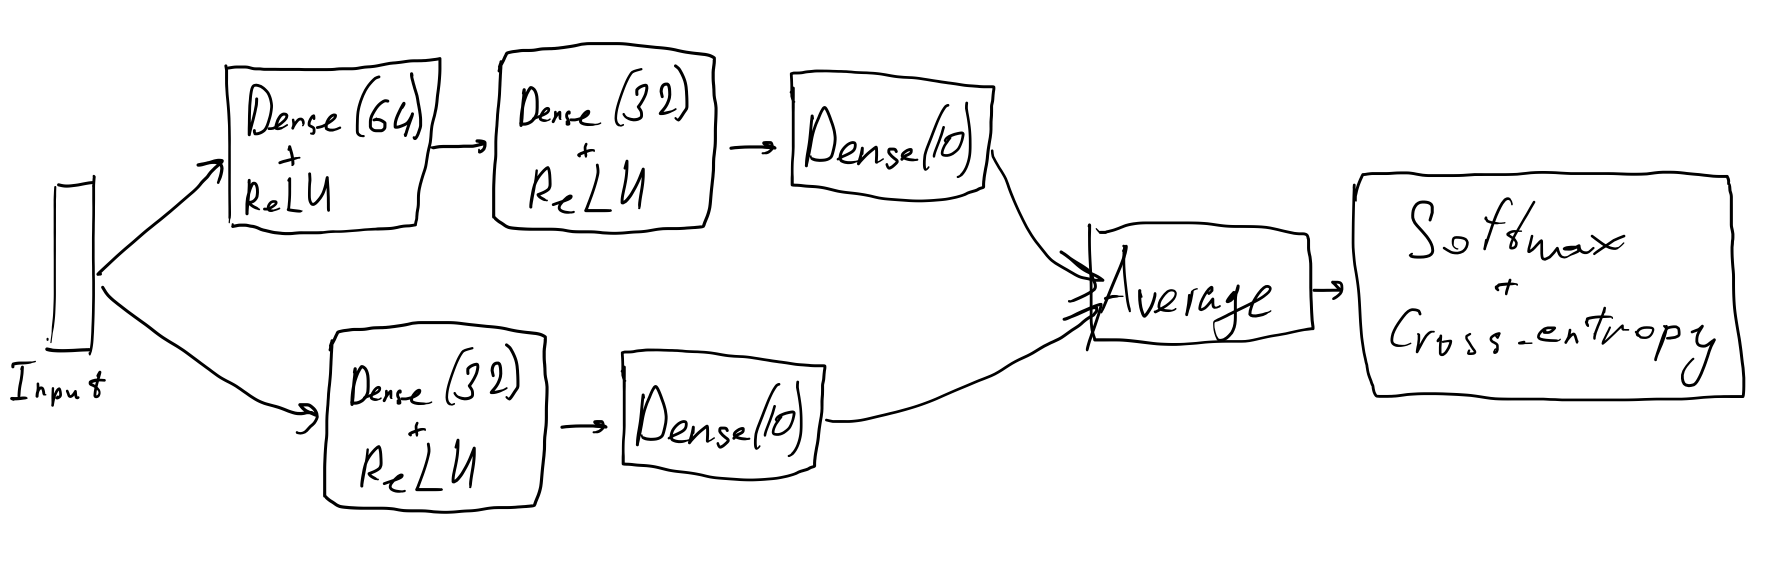

In [6]:
import torch.nn as nn            # for torch.nn.Module, the parent object for PyTorch models
import torch.nn.functional as F

In [7]:
if torch.cuda.is_available():
    my_device = torch.device('cuda')
else:
    my_device = torch.device('cpu')

In [8]:
seq_modules_1 = nn.Sequential(
    nn.Flatten(),   
    nn.Linear(in_features=28*28, out_features=64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 10)
)

seq_modules_2 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 32),
    nn.ReLU(),
    nn.Linear(32, 10)
)



In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.part1 = seq_modules_1
        self.part2 = seq_modules_2
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x_1 = self.part1(x)
        x_2 = self.part2(x)
        x_res = 0.5 * x_1 + 0.5 * x_2
        #return self.softmax(x_res) 
        return x_res

        # it is written in documentation that cross entropy does logsoftmax therefore I'm not sure whether I should return softmaxed value or not

In [10]:
import torch.optim as optim

In [11]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
output = net(trainloader)
softmax = nn.Softmax(dim=1)
pred_probab = softmax(output)


In [15]:
net.to(my_device)

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(my_device))
        loss = criterion(outputs, labels.to(my_device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        print(running_loss)
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

2.313966751098633
4.63810133934021
6.909421920776367
9.243143796920776
11.541544914245605
13.84619426727295
16.096778631210327
18.407979249954224
20.70492720603943
23.0201153755188
25.303025722503662
27.60527801513672
29.87444543838501
32.135568618774414
34.45091152191162
36.71887421607971
38.98643112182617
41.22767758369446
43.49228620529175
45.733675956726074
47.9936101436615
50.231759786605835
52.46112370491028
54.67139029502869
56.904075145721436
59.13375663757324
61.35561156272888
63.593849182128906
65.8161792755127
68.0347101688385
70.24605417251587
72.43953585624695
74.63883876800537
76.8150520324707
78.99595403671265
81.18260359764099
83.36938762664795
85.55570340156555
87.73503136634827
89.93051862716675
92.116046667099
94.28968906402588
96.42940855026245
98.5756995677948
100.74327325820923
102.9129285812378
105.05388021469116
107.16843295097351
109.34860634803772
111.46604657173157
113.58918452262878
115.75311541557312
117.86774969100952
120.0285758972168
122.13090682029724
1

In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
      # get the inputs
        inputs, labels = data

        # forward + backward + optimize
        outputs = net(inputs.to(my_device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(my_device)).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 81 %
